### Code for creating gifs of consecutive wrfout files

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from wrf import to_np, getvar, CoordPair, vertcross, latlon_coords, interplevel, smooth2d
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import glob
import wrf
from netCDF4 import Dataset
import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.plots import Hodograph, SkewT
from metpy.units import units
import matplotlib.gridspec as gridspec
import imageio
from metpy.plots import ctables


In [2]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color
    lon = plotting longitude values (2D)
    lat = plotting latitude values (2D)
    data = 2D data that you wish to plot the max/min symbol placement
    extrema = Either a value of max for Maximum Values or min for Minimum Values
    nsize = Size of the grid box to filter the max and min values to plot a reasonable number
    symbol = String to be placed at location of max/min value
    color = String matplotlib colorname to plot the symbol (and numerica value, if plotted)
    plot_value = Boolean (True/False) of whether to plot the numeric value of max/min point
    The max/min symbol will be plotted on the current axes within the bounding frame
    (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=24,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], "L",
                color=color, size=12, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)

/opt/tljh/user/envs/MEA443/lib/python3.11/site-packages/matplotlib/contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/opt/tljh/user/envs/MEA443/lib/python3.11/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter-legetker@ncsu.edu/wrf/dbz_plots/control_dbz_plot_00.png'

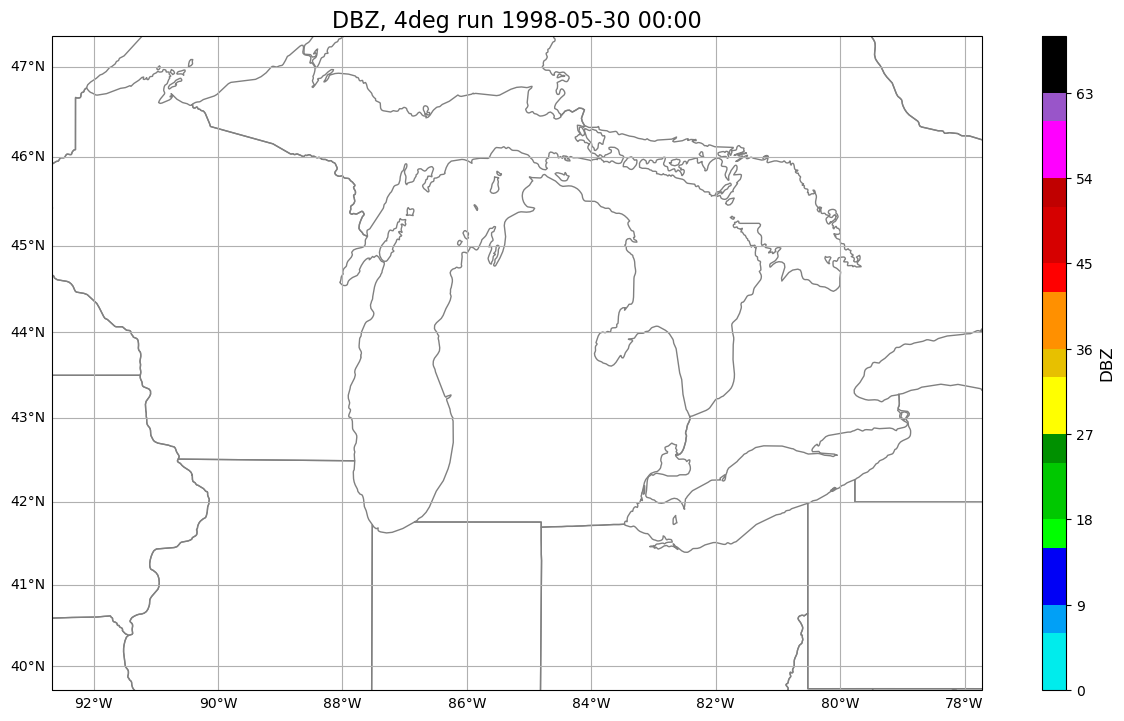

In [3]:
"""
Create DBZ loop
"""
plots_dir = "/home/jupyter-legetker@ncsu.edu/wrf_codes/dbz_plots/"
control_files = glob.glob("/scratch/legetker/wdm_4deg_delta/wrfout_d02*")
control_files = sorted(control_files)
images = []
for i in range(len(control_files)):
    if i < 10:
        plot_name = "control_dbz_plot_0" + str(i)
    else:
        plot_name = "control_dbz_plot_" + str(i)
    ctrl_data_step = Dataset(control_files[i], "r", format="NETCDF4")
    
    time=wrf.extract_times(ctrl_data_step, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(time))
    titletime=(timestr[0:10]+' '+timestr[11:16])
    
    mdbz_ctrl = getvar(ctrl_data_step, "mdbz")
    #slp = getvar(ctrl_data_step, "slp")
    #smooth_slp = smooth2d(slp, 10, cenweight=4)
    #theta = getvar(ctrl_data_step, "th")
    #p_ctrl = getvar(ctrl_data_step, "pressure")
    mdbz_plot_ctrl = np.where(mdbz_ctrl > 0., mdbz_ctrl, "NaN")
    lats, lons = latlon_coords(mdbz_ctrl)
    fig = plt.figure(figsize=(12,12))
    ax = plt.axes(projection=ccrs.Mercator(central_longitude = 0))
    ax.add_feature(cfeature.STATES, edgecolor='gray')  #Add US states
    ax.add_feature(cfeature.COASTLINE, edgecolor='gray')  #Add coastlines
    cs = ax.contourf(lons, lats, mdbz_plot_ctrl, cmap = ctables.registry.get_colortable('NWSReflectivity'), transform=ccrs.PlateCarree(), levels = np.arange(0, 70, 3))
    #slp_c = ax.contour(lons, lats, smooth_slp, colors = 'black', transform=ccrs.PlateCarree(), levels = np.arange(980, 1030, 4))
    #ax.clabel(slp_c)
    #plot_maxmin_points(lons, lats, slp, 'min', 500, "L", color='red',
    #                   plotValue=True, transform=ccrs.PlateCarree())
    #ax.scatter(lon1, lat1, color = 'white', transform=ccrs.PlateCarree(), edgecolors = 'black')
    #ax.scatter(lon2, lat2, color = 'white', transform=ccrs.PlateCarree(), edgecolors = 'black')
    #ax.plot([lon1,lon2], [lat1, lat2], color = 'black', transform=ccrs.PlateCarree())
    cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])  #You can change the numbers to move the colorbar.
    cbar = plt.colorbar(cs, cax = cax)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels=False   # suppress top grid labels
    gl.right_labels=False # suppress right grid labels
    ax.set_title("DBZ, 4deg run " + titletime, fontsize = 16)
    cbar.set_label("DBZ", fontsize = 12)
    plt.savefig(plots_dir+plot_name, bbox_inches = "tight")
    plt.close()
    images.append(imageio.imread(plots_dir + plot_name + ".png"))
imageio.mimsave('dbz_4deg.gif', images, duration=.5)


In [ ]:
"""
Create heat flux difference field loop
"""
from scipy import signal
ctrl_dir = "/home/jupyter-legetker@ncsu.edu/wrf/ctrl_plots/"
delta_dir = "/home/jupyter-legetker@ncsu.edu/wrf/delta_plots/"
control_files = glob.glob("/scratch/legetker/wdm_ctrl_run/wrfout_d02*")
delta_files = glob.glob("/scratch/legetker/wdm_4deg_delta/wrfout_d02*")
control_files = sorted(control_files)
delta_files = sorted(delta_files)
images_ctrl = []
images_delta = []
for i in range(len(control_files)):
    if i < 10:
        plot_name = "control_lcl_0" + str(i)
    else:
        plot_name = "control_lcl_" + str(i)
    ctrl_data_step = Dataset(control_files[i], "r", format="NETCDF4")
    delta_data_step = Dataset(delta_files[i], "r", format="NETCDF4")
    
    time=wrf.extract_times(ctrl_data_step, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(time))
    titletime=(timestr[0:10]+' '+timestr[11:16])
    
    hfx_ctrl = wrf.getvar(ctrl_data_step,"HFX",timeidx=0)
    hfx_delta = wrf.getvar(delta_data_step,"HFX",timeidx=0)
    """
    p = wrf.getvar(ctrl_data_step,"pressure",timeidx=0)
    T = wrf.getvar(ctrl_data_step,"tc",timeidx=0)
    Td = wrf.getvar(ctrl_data_step,"td",timeidx=0)
    lcl_pressure_ctrl, lcl_temperature_ctrl = mpcalc.lcl(p[0,:,:], T[0,:,:], Td[0,:,:])
    
    p = wrf.getvar(delta_data_step,"pressure",timeidx=0)
    T = wrf.getvar(delta_data_step,"tc",timeidx=0)
    Td = wrf.getvar(delta_data_step,"td",timeidx=0)
    lcl_pressure_delta, lcl_temperature_delta = mpcalc.lcl(p[0,:,:], T[0,:,:], Td[0,:,:])
    """
    lats, lons = latlon_coords(hfx_ctrl)
    fig1 = plt.figure(figsize=(16,16))
    ax1 = plt.axes(projection=ccrs.Mercator(central_longitude = 0))
    
    ax1.add_feature(cfeature.STATES, edgecolor='black')  #Add US states
    ax1.add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines
    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels=False   # suppress top grid labels
    gl.right_labels=False # suppress right grid labels
    cs1 = ax1.contourf(lons, lats, hfx_delta - hfx_ctrl, cmap = "bwr", transform=ccrs.PlateCarree(), levels = np.arange(-500, 500, 40))
    cax = fig1.add_axes([ax1.get_position().x1+0.05,ax1.get_position().y0,0.02,ax1.get_position().height])  #You can change the numbers to move the colorbar.
    cbar = plt.colorbar(cs1, cax = cax)
                       
    ax1.set_title("Sensible Heat flux difference field, 4 deg delta minus control, " + titletime, fontsize = 16)
    cbar.set_label("Heat Flux (W/m2)", fontsize = 12)
    plt.savefig(ctrl_dir+plot_name)
    plt.close()
    images_ctrl.append(imageio.imread(ctrl_dir + plot_name + ".png"))                   
                       
    """
    ax2.add_feature(cfeature.STATES, edgecolor='black')  #Add US states
    ax2.add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines
    gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels=False   # suppress top grid labels
    gl.right_labels=False # suppress right grid labels
    cs2 = ax2.contourf(lons, lats, lcl_pressure, cmap = "jet", transform=ccrs.PlateCarree(), levels = np.arange(500, 1020, 20))
    cbar = plt.colorbar(cs2, cax = cax)
    
    """
imageio.mimsave('hfx_diff.gif', images_ctrl, duration=.5)
